<a href="https://colab.research.google.com/github/KaustavRaj/Image-Captioning/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <font color = "green"> Image Captioning </font> <h1>
<hr>

This notebook shows how to generate image captions using '*Merge model*'

So lets first connect our google colab to google drive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<h3> <font color = "16B4EF"> Importing Libraries </font> </h3>
<hr width = 60% align=left>

In [0]:
import os
import re
import pickle
import logging
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from keras import Input
from keras.models import Model
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, Reshape, concatenate, Dropout
import warnings
warnings.filterwarnings('ignore')

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)

In [0]:
!pip install contractions

     |████████████████████████████████| 245kB 3.9MB/s 
     |████████████████████████████████| 317kB 57.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81711 sha256=6e2c085987c8c9aaddad7d886a145c11149bdc6ef3e6d9a083f4a22ea78fe25b
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [0]:
!pip install rouge

In [0]:
import contractions

In [0]:
dir_path = '/content/gdrive/My Drive/Colab Notebooks/image captioning/'

<h3> <font color = "16B4EF"> Data Cleaning and Preprocessing </font> </h3>
<hr width = 60% align=left>

In [0]:
# Declaring the important variables here, which will be used later down the notebook

_TEXT_PADDING    =   'post'
_BATCH_SIZE      =   3
_EPOCHS          =   30
_LSTM_DIMS       =   256
_EMBEDDING_DIMS  =   200
_MAX_TEXT_LEN    =   0
_TARGET_IMG_SIZE =   (299, 299)
_VOCAB_SIZE      =   0


In [0]:
# Text cleaner for cleaning captions

def cleaner(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text.lower(), flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = contractions.fix(text, slang=False)
  return text

In [0]:
# For separating image and captions from the text file and appending
# 'stok' (start token) and 'etok' (end token) in captions

def prepare_description(path):
  global _MAX_TEXT_LEN
  
  with open(path, 'r') as f:
    data = f.readlines()

  store_result = dict()
  maxlength = 0

  for row in data:
    words = row.split()
    if len(words) >= 2:
      name, caption = words[0], words[1:]
      name = name.split('.')[0]
      caption = 'stok ' + cleaner(' '.join(caption)) + ' etok'
      maxlength = max(maxlength, len(caption.split()))
      if name not in store_result.keys():
        store_result[name] = [caption]
      else:
        store_result[name].append(caption)
  
  _MAX_TEXT_LEN = maxlength

  return store_result

In [0]:
# Loading cleaned description and saving

descriptions_path = dir_path + 'data/Flickr8k.token.txt'
descriptions = prepare_description(descriptions_path)
pickle.dump(descriptions, open(dir_path + 'data/descriptions.pkl', 'wb'))

In [0]:
# Skip this part if description is already loaded

descriptions = pickle.load(open(dir_path + 'data/descriptions.pkl', 'rb'))

In [0]:
# Listing all images available in Flicker dataset directory

images_dir_path = dir_path + 'data/Flicker8k_Dataset/'
all_listed_file = os.listdir(images_dir_path)
all_images = list()

for file_name in all_listed_file:
  if '.jpg' in file_name:
    all_images.append(file_name)

In [0]:
len(all_listed_file), len(all_images)

(8091, 8091)

Since we are already given the training and testing datasets, so we can simply check the files and saves the image filenames from it.

In [0]:
# Putting training images from all_images_list

train_images_path = dir_path + 'data/Flickr_8k.trainImages.txt'
train_images_name = set(open(train_images_path, 'r').read().strip().split('\n'))
train_images = list()

for _image in all_images:
  if _image in train_images_name:
    train_images.append(_image)

In [0]:
len(train_images)

6000

In [0]:
# Putting testing images from all_images_list

test_images_path = dir_path + 'data/Flickr_8k.testImages.txt'
test_images_name = set(open(test_images_path, 'r').read().strip().split('\n'))
test_images = list()

for _image in all_images:
  if _image in test_images_name:
    test_images.append(_image)

In [0]:
len(test_images)

1000

In [0]:
def load_descriptions_from_dataset(descriptions, dataset):
  store = dict()
  for _image, _desc in descriptions.items():
    if _image+'.jpg' in dataset:
      store[_image] = _desc
  return store

train_descriptions = load_descriptions_from_dataset(descriptions, train_images_name)
test_descriptions  = load_descriptions_from_dataset(descriptions, test_images_name)

In [0]:
def feature_extractor(image_path, img_model):
  global _TARGET_IMG_SIZE
  
  _image = image.load_img(image_path, target_size=_TARGET_IMG_SIZE)
  _image = image.img_to_array(_image)
  _image = np.expand_dims(_image, axis=0)
  _image = preprocess_input(_image)

  extracting_model = Model(img_model.input, img_model.layers[-2].output)
  features = extracting_model.predict(_image)
  features = np.reshape(features, features.shape[1])

  return features

In [0]:
inception_model = InceptionV3()

96116736/96112376 [==============================] - 1s 0us/step


In [0]:
encoding_train = dict()
for _image in train_images:
  image_path = dir_path + 'data/Flicker8k_Dataset/' + _image
  encoding_train[_image] = feature_extractor(image_path, inception_model)

In [0]:
pickle.dump(encoding_train, open(dir_path + 'data/encoded_train_images_inception.pkl', 'wb'))

In [0]:
encoding_test = dict()
for _image in test_images:
  image_path = dir_path + 'data/Flicker8k_Dataset/' + _image
  encoding_test[_image] = feature_extractor(image_path, inception_model)

In [0]:
pickle.dump(encoding_test, open(dir_path + 'data/encoded_test_images_inception.pkl', 'wb'))

In [0]:
# Skip this part if encoding_train & encoding_test is already loaded

encoding_train = pickle.load(open(dir_path + 'data/encoded_train_images_inception.pkl', 'rb'))
encoding_test = pickle.load(open(dir_path + 'data/encoded_test_images_inception.pkl', 'rb'))

In [0]:
# List of all the training captions

all_training_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_training_captions.append(cap)
        
len(all_training_captions)

30000

In [0]:
# Words occuring at least 5 times will be included in our vocabulary

threshold = 5
word_counts = {}

for sent in all_training_captions:
  for word in sent.split(' '):
    word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
len(word_counts), len(vocab)

(7336, 2532)

In [0]:
# word to index and index to word converter

index_to_word = {}
word_to_index = {}

index = 1
for word in vocab:
    word_to_index[word] = index
    index_to_word[index] = word
    index += 1

pickle.dump([word_to_index, index_to_word], open(dir_path + 'models/word_index_mapping.pkl', 'wb'))

In [0]:
# Skip this part if index_to_word and word_to_index is already loaded

word_to_index, index_to_word = pickle.load(open(dir_path + 'models/word_index_mapping.pkl', 'rb'))

In [0]:
_VOCAB_SIZE = len(word_to_index) + 1
_VOCAB_SIZE

2533

In [0]:
embeddings_index = dict()

with open(dir_path + 'data/glove.6B.200d.txt', encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Total no. of word embeddings = {}'.format(len(embeddings_index)))

Total no. of word embeddings = 400000


In [0]:
embedding_matrix = np.zeros((_VOCAB_SIZE, _EMBEDDING_DIMS ))

for word, index in word_to_index.items():
    embedding = embeddings_index.get(word)
    if word in embeddings_index:
      embedding_matrix[index] = embedding

embedding_matrix.shape

(2533, 200)

<h3> <font color = "16B4EF"> Merge Model </font> </h3>
<hr width = 60% align=left>

In [0]:
def create_model():
  global _EMBEDDING_DIMS, _VOCAB_SIZE, _MAX_TEXT_LEN, _LSTM_DIMS

  # Image input
  img_input = Input(shape=(2048,))
  drop_layer1 = Dropout(0.5)(img_input)
  img_model = Dense(_LSTM_DIMS, activation='relu')(drop_layer1)
  
  # Text input
  text_input = Input(shape=(_MAX_TEXT_LEN,))
  embedding = Embedding(_VOCAB_SIZE, _EMBEDDING_DIMS, mask_zero=True)(text_input)
  drop_layer2 = Dropout(0.5)(embedding)
  text_model = LSTM(_LSTM_DIMS)(drop_layer2)
  
  # Merged
  merged = add([img_model, text_model])
  merged = Dense(_LSTM_DIMS, activation='relu')(merged)
  output = Dense(_VOCAB_SIZE, activation='softmax')(merged)
  
  # Final model
  model = Model(inputs=[img_input, text_input], outputs=output)
  return model

In [0]:
# Breaks each a sentence into series of (sequence, next_word)

def break_sent(sentences, word_to_index):
  global _MAX_TEXT_LEN, _VOCAB_SIZE

  sequences  = list()

  for sentence in sentences:
    sent = [word_to_index[word] for word in sentence.split(' ') if word in word_to_index]
    for i in range(1, len(sent)):
      seq, word = sent[:i], sent[i]
      seq = pad_sequences([seq], maxlen = _MAX_TEXT_LEN, padding=_TEXT_PADDING)[0]
      word = to_categorical([word], num_classes = _VOCAB_SIZE)[0]
      sequences.append((seq, word))

  return sequences

In [0]:
# Data generator

def data_generator(descriptions, images, word_to_index):
  global _MAX_TEXT_LEN, _VOCAB_SIZE, _BATCH_SIZE
  img, seq, next_word = list(), list(), list()
  count = 0
  while True:
    for name, captions in descriptions.items():
      count += 1
      _image = images[name + '.jpg']
      sequences = break_sent(captions, word_to_index)
      for sequence in sequences:
        X, y = sequence
        img.append(_image)
        seq.append(X)
        next_word.append(y)
      if count == _BATCH_SIZE:
        yield [[np.array(img), np.array(seq)], np.array(next_word)]
        img, seq, next_word = list(), list(), list()
        count = 0

In [0]:
model = create_model()

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      506600      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
# Skip this step if model weights are not saved

model.load_weights(dir_path + 'models/model_30_weights.h5')

<h3> <font color = "16B4EF"> Training the Model </font> </h3>
<hr width = 60% align=left>

You can skip this section if the model already is saved in **/models** section

In [0]:
steps_per_epoch = len(train_descriptions) // _BATCH_SIZE

for i in range(1, _EPOCHS+1):
  generator = data_generator(train_descriptions, encoding_train, word_to_index)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)
  save_path = '{}models/model{}.h5'.format(dir_path, i)
  model.save(save_path)

Epoch 1/1
2000/2000 [==============================] - 188s 94ms/step - loss: 3.3323
Epoch 1/1
2000/2000 [==============================] - 174s 87ms/step - loss: 2.7141
Epoch 1/1
2000/2000 [==============================] - 170s 85ms/step - loss: 2.5277
Epoch 1/1
2000/2000 [==============================] - 167s 83ms/step - loss: 2.4138
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.3315
Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 2.2675
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.2151
Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 2.1734
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.1374
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.1072
Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 2.0811
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/

In [0]:
model.save_weights(dir_path + 'models/model_30_weights.h5')

<h3> <font color = "16B4EF"> Testing the Model </font> </h3>
<hr width = 60% align=left>

For inference, I am using both greedy decoder and beam search decoder

In [0]:
def greedy_decoder(_image, model, word_to_index):
  global _MAX_TEXT_LEN

  decoded_text = 'stok'

  for i in range(_MAX_TEXT_LEN):
    sequence = [word_to_index[word] for word in decoded_text.split() if word in word_to_index]
    sequence = pad_sequences([sequence], maxlen = _MAX_TEXT_LEN)
    pred = model.predict([_image, sequence], verbose=0)
    pred = np.argmax(pred)
    word = index_to_word[pred]
    decoded_text += ' ' + word
    if word == 'etok':
      break

  s = decoded_text.split()
  if 'etok' in s: s.remove('etok')
  if 'stok' in s: s.remove('stok')

  return ' '.join(s)

In [0]:
from scipy.special import softmax

def beam_search_decoder(_image, model, word_to_index, k=3, return_seq=3):
  global _MAX_TEXT_LEN
  assert k >= 0
  assert return_seq > 0 and return_seq <= k

  decoded_text = [('stok', 0.0)]*k

  for i in range(_MAX_TEXT_LEN):
    new_texts = []

    for segment in decoded_text:
      text, total_prob = segment
      sequence = [word_to_index[word] for word in text.split() if word in word_to_index]
      sequence = pad_sequences([sequence], maxlen = _MAX_TEXT_LEN)
      predictions = model.predict([_image, sequence], verbose=0)[0]
      log_probs = np.log(softmax(predictions))
      indices = np.argsort(log_probs)[-k:]

      for index in indices:
        word = index_to_word[index]
        new_sent = ''
        new_prob = 0.0

        if 'etok' in text:
          new_sent = sent
          new_prob = prob

        elif word == 'etok':
          new_sent = text + ' etok'
          new_prob = total_prob + log_probs[index]

        else:
          if word == '':
            new_sent = text
          else:
            new_sent = text + ' ' + word
          new_prob = total_prob + log_probs[index]

        new_texts.append((new_sent, new_prob))

    new_texts.sort(key = lambda new_texts: new_texts[1])
    decoded_text = new_texts[-k:]

  text = []
  for row in decoded_text:
    s, _ = row
    s = s.split()
    if 'etok' in s: s.remove('etok')
    if 'stok' in s: s.remove('stok')
    text.append(' '.join(s))

  return text[:return_seq]

In [0]:
def tester_greedy(path_to_image, model):
  image_features = feature_extractor(path_to_image, inception_model).reshape((1,2048))
  x = plt.imread(path_to_image)
  plt.imshow(x)
  plt.show()
  print("Caption: {}".format(greedy_decoder(image_features, model, word_to_index)))

In [0]:
def tester_beam_search(path_to_image, model):
  image_features = feature_extractor(path_to_image, inception_model).reshape((1,2048))
  x = plt.imread(path_to_image)
  plt.imshow(x)
  plt.show()
  print("Caption: {}".format(beam_search_decoder(image_features, model, word_to_index, return_seq=1)))

In [0]:
image_path = dir_path + 'data/Flicker8k_Dataset/69189650_6687da7280.jpg'

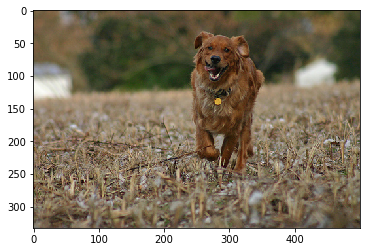

Caption: a brown dog is running through the grass


In [0]:
tester_greedy(image_path, model)

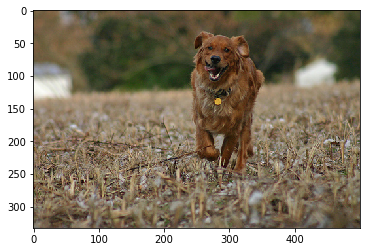

Caption: ['a brown dog is running through the grass']


In [0]:
tester_beam_search(image_path, model);

Let's try other pictures as well

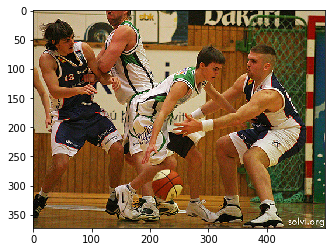

Caption: ['a basketball player in a white outfit is dribbling the ball']


In [0]:
image_path = dir_path + 'data/Flicker8k_Dataset/3072172967_630e9c69d0.jpg'
tester_beam_search(image_path, model);

Perfect caption ! let's try some more

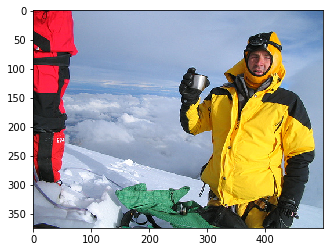

Caption: ['a man in a red jacket is walking through the snow']


In [0]:
image_path = dir_path + 'data/Flicker8k_Dataset/55470226_52ff517151.jpg'
tester_beam_search(image_path, model);

Everything ok except **'red'** jacket which should be **'yellow'**

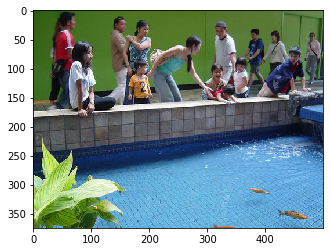

Caption: ['a man is sitting on a bench with a pole in front of a building']


In [0]:
image_path = dir_path + 'data/Flicker8k_Dataset/12830823_87d2654e31.jpg'
tester_beam_search(image_path, model);

Well not quite correct...

Let's try one picture from our side

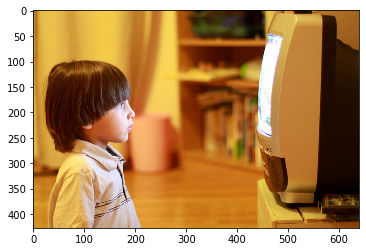

Caption: ['a man in a black shirt is operating a video camera']


In [0]:
image_path = dir_path + 'examples/example1.jpg'
tester_beam_search(image_path, model);

Not a correct caption, let's try one final picture

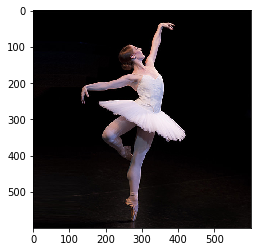

Caption: ['a girl in a pink tutu dances in a puddle']


In [0]:
image_path = dir_path + 'examples/example2.jpg'
tester_beam_search(image_path, model);

Quite impressive except for the **'puddle'**.

<h3> <font color = "16B4EF"> Evaluation metric </font> </h3>
<hr width = 60% align=left>

Here I am using both ***bleu score*** and ***rouge score*** to evaluate the model's captions.

Let's first start with bleu score

In [0]:
def generate_test_captions(model):
  global encoding_test, word_to_index

  features = list(encoding_test.values())
  generated_captions = list()
  
  for feature in features:
    feature = feature.reshape((1,2048))
    generated_captions.append(beam_search_decoder(feature, model, word_to_index, return_seq=1))

  return generated_captions

In [0]:
hypothesis = generate_test_captions(model)

In [0]:
reference  = list(test_descriptions.values())

In [0]:
reference = [i[0].split()[1:-1] for i in reference]

In [0]:
hypothesis = [i[0].split() for i in hypothesis]

In [0]:
len(reference), len(hypothesis)

(1000, 1000)

In [0]:
from nltk.translate.bleu_score import corpus_bleu

print('bleu score for 1-gram : {}'.format(corpus_bleu(reference, hypothesis, weights=(1.0, 0, 0, 0))))
print('bleu score for 2-gram : {}'.format(corpus_bleu(reference, hypothesis, weights=(0.5, 0.5, 0, 0))))
print('bleu score for 3-gram : {}'.format(corpus_bleu(reference, hypothesis, weights=(0.33, 0.33, 0.33, 0))))
print('bleu score for 4-gram : {}'.format(corpus_bleu(reference, hypothesis, weights=(0.25, 0.25, 0.25, 0.25))))

bleu score for 1-gram : 0.10469886257691592
bleu score for 2-gram : 0.32357203614792784
bleu score for 3-gram : 0.47487668547155104
bleu score for 4-gram : 0.5688339266850456


And now for rouge score

In [0]:
from rouge import Rouge

scorer = Rouge()

In [0]:
# storing all the rouge scores
rouge_1 = {'f':[], 'p':[], 'r':[]}
rouge_2 = {'f':[], 'p':[], 'r':[]}
rouge_l = {'f':[], 'p':[], 'r':[]}

In [0]:
hypothesis = [' '.join(i) for i in hypothesis]
reference = [' '.join(i) for i in reference]

In [0]:
rouge_scores = scorer.get_scores(hypothesis, reference)

for entry in rouge_scores:
  one, two, l = entry['rouge-1'], entry['rouge-2'], entry['rouge-l']
  for p, q in one.items():
    rouge_1[p].append(q)
  for p, q in two.items():
    rouge_2[p].append(q)
  for p, q in l.items():
    rouge_l[p].append(q)

In [0]:
pickle.dump(hypothesis, open(dir_path + 'data/hypothesis.pkl', 'wb'))

Our average rouge scores are :

In [0]:
np.mean(rouge_1['f']), np.mean(rouge_1['p']), np.mean(rouge_1['r'])

(0.2000991924197432, 0.21360161227661228, 0.20251775117988607)

In [0]:
np.mean(rouge_2['f']), np.mean(rouge_2['p']), np.mean(rouge_2['r'])

(0.03501257551911372, 0.036064512955225024, 0.03789400609423829)

In [0]:
np.mean(rouge_l['f']), np.mean(rouge_l['p']), np.mean(rouge_l['r'])

(0.17913656909888082, 0.2021681512931513, 0.19296384238658099)

A consise table of the above values is given below for comparing

<table>
<tbody>
<tr>
<td></td>
<td>f1 score</td>
<td>precision</td>
<td>recall</td>
</tr>
<tr>
<td>Rouge-1</td>
<td>0.20</td>
<td>0.21</td>
<td>0.20</td>
</tr>
<tr>
<td>Rogue-2</td>
<td>0.04</td>
<td>0.04</td>
<td>0.04</td>
</tr>
<tr>
<td>Rogue-l</td>
<td>0.18</td>
<td>0.20</td>
<td>0.19</td>
</tr>
</tbody>
</table>

<h3> <font color = "16B4EF"> Conclusion </font> </h3>
<hr width = 60% align=left>

The Model is working out well but it has some flaws such as, wrong prediction of colors and gender. To ensure better accuracy, larger dataset and other image captioning architectures should be used.